In [ ]:
# Install dependencies.
from google.colab import drive
# drive.mount('/content/drive')

!rm -r sample_data
!pip install -qq --upgrade transformers compel accelerate git+https://github.com/huggingface/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 41.4 MB/s eta 0:00:00


In [ ]:
# Set the details for your model here:
import torch

from diffusers import AutoencoderKL, StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, \
KDPM2AncestralDiscreteScheduler, DPMSolverSinglestepScheduler, DPMSolverMultistepScheduler, PNDMScheduler, \
DDIMScheduler, LMSDiscreteScheduler, DDPMScheduler, HeunDiscreteScheduler, UniPCMultistepScheduler, \
DEISMultistepScheduler, KDPM2DiscreteScheduler, EulerAncestralDiscreteScheduler, EulerDiscreteScheduler

use_refiner = False

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
# base.load_lora_weights("stabilityai/stable-diffusion-xl-base-1.0", weight_name="sd_xl_offset_example-lora_1.0.safetensors", alpha=0.5)

_ = base.to("cuda")

if use_refiner:
  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      text_encoder_2=base.text_encoder_2,
      torch_dtype=torch.float16,
      variant="fp16",
      use_safetensors=True,
  )
  # refiner.scheduler = scheduler
  _ = refiner.to("cuda")

tokenizer = base.tokenizer            # cpu
tokenizer_2 = base.tokenizer_2        # cpu
text_encoder = base.text_encoder      # cuda
text_encoder_2 = base.text_encoder_2  # cuda
unet = base.unet                      # cuda

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

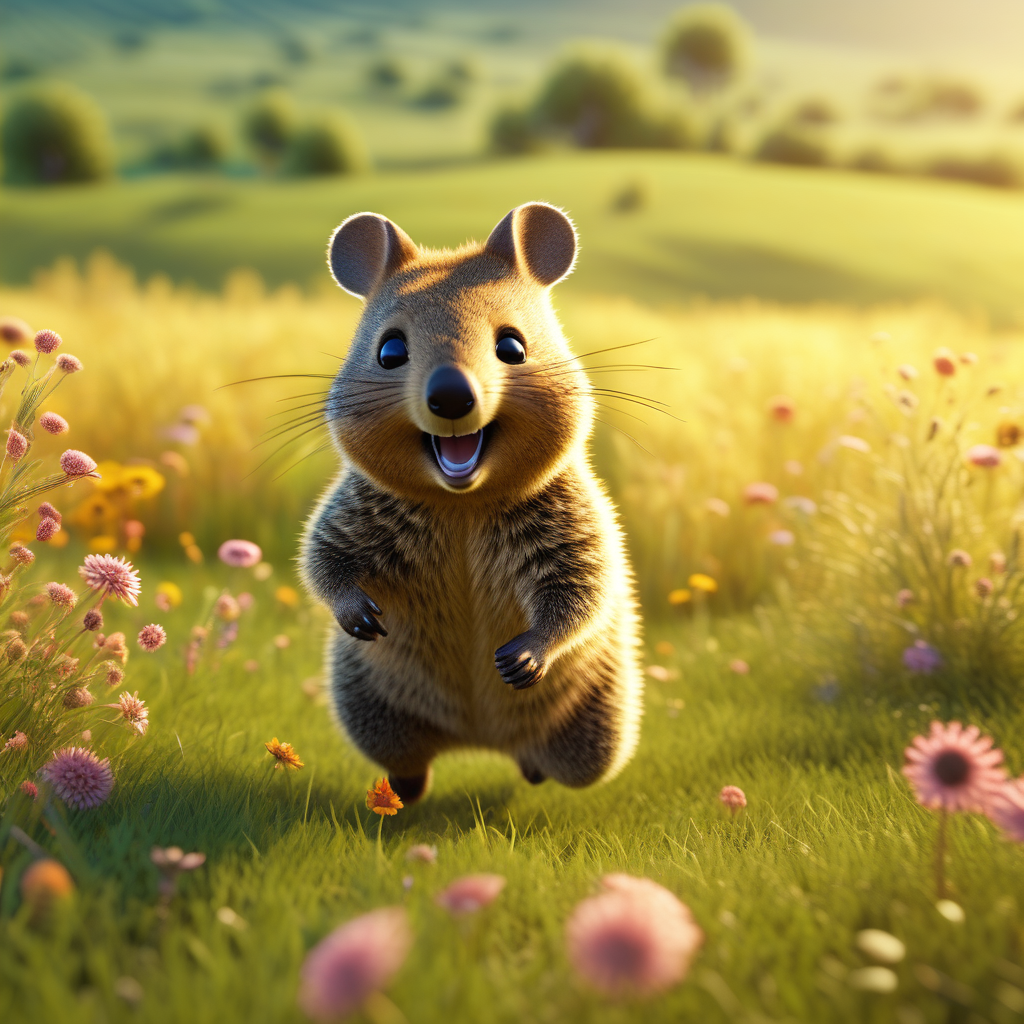

In [ ]:
prompt="Cute anthrophomorphic Quokka happily running on the beautiful meadow, pixar, volumetric lighting"
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt += "colorful, funny, intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

num_inference_steps = 30
guidance_scale = 10

def soft_clamp_tensor(input_tensor, threshold=3.5, boundary=4):
    if max(abs(input_tensor.max()), abs(input_tensor.min())) < 4:
        return input_tensor
    channel_dim = 1

    max_vals = input_tensor.max(channel_dim, keepdim=True)[0]
    max_replace = ((input_tensor - threshold) / (max_vals - threshold)) * (boundary - threshold) + threshold
    over_mask = (input_tensor > threshold)

    min_vals = input_tensor.min(channel_dim, keepdim=True)[0]
    min_replace = ((input_tensor + threshold) / (min_vals + threshold)) * (-boundary + threshold) - threshold
    under_mask = (input_tensor < -threshold)

    return torch.where(over_mask, max_replace, torch.where(under_mask, min_replace, input_tensor))

def normalize_tensor(input_tensor, boundary=3.83877):
    min_val = input_tensor.min()
    max_val = input_tensor.max()

    normalization_factor = boundary / max(abs(min_val), abs(max_val))

    return input_tensor * normalization_factor

def center_tensor(input_tensor, channel_shift=1, full_shift=1, channels=[0, 1, 2, 3]):
    for channel in channels:
        input_tensor[0, channel] -= input_tensor[0, channel].mean() * channel_shift
    return input_tensor - input_tensor.mean() * full_shift

def callback(pipe, step_index, timestep, cbk):
    print(cbk["latents"].mean())
    if timestep > 950:
        threshold = max(cbk["latents"].max(), abs(cbk["latents"].min())) * 0.995
        cbk["latents"] = soft_clamp_tensor(cbk["latents"], threshold*0.995, threshold)
    if timestep > 700:
        cbk["latents"] = center_tensor(cbk["latents"], 0.8, 0.8)
    if timestep == 1:
        cbk["latents"] = center_tensor(cbk["latents"], 0.6, 1.0)
        cbk["latents"] = normalize_tensor(cbk["latents"])
    return cbk

image = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale = guidance_scale, generator=torch.manual_seed(2222), callback_on_step_end_tensor_inputs=["latents"], denoising_end=0.8 if use_refiner else 1.0, output_type="latent" if use_refiner else "pil").images
if use_refiner: image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, generator=torch.manual_seed(2222), denoising_start=0.8, image=image).images
display(image[0])

In [ ]:
"""
import os
import time
import diffusers
from diffusers import PNDMScheduler

prompt="Photograph of a beautiful woman standing in a lush garden"
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

for use_karras_sigmas in [True]:
    for scheduler in base.scheduler.compatibles:
        scheduler_name = scheduler.__name__
        if scheduler_name in ("PNDMScheduler", "KDPM2AncestralDiscreteScheduler"):
            ske = scheduler.from_config(base.scheduler.config, use_karras_sigmas=use_karras_sigmas)
            base.scheduler = ske
            for num_inference_steps in range(5, 36, 5):
                print("Generating with", scheduler_name)
                start_time = time.time()
                latents = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_end=0.8, output_type="latent").images
                image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_start=0.8, image=latents).images[0]
                folder_path = f"/content/drive/MyDrive/schedulers/{'k' if use_karras_sigmas else ''}{num_inference_steps}"
                os.makedirs(folder_path, exist_ok=True)
                image.save(f"{folder_path}/{str(round(float(time.time()-start_time),2)).replace('.', ',')}_{scheduler_name}.png")
"""

In [ ]:
import torch
from compel import Compel, ReturnedEmbeddingsType

def process_prompt(pipeline, prompt_1='', negative_prompt_1='', prompt_2='', negative_prompt_2=''):
    compel_config = {
        "tokenizer": [pipeline.tokenizer, pipeline.tokenizer_2],
        "text_encoder": [pipeline.text_encoder, pipeline.text_encoder_2],
        "requires_pooled": [False, True],
    }
    compel_config_1 = {key: value[0] for key, value in compel_config.items()}
    compel_config_2 = {key: value[1] for key, value in compel_config.items()}
    common_config = {
        "truncate_long_prompts": False,
        "returned_embeddings_type": ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    }
    if not pipeline.tokenizer or (prompt_2 == "" and negative_prompt_2 == ""):
        if not pipeline.tokenizer:
            compel_config = compel_config_2

        compel = Compel(**compel_config, **common_config)
        prompt_embeds, prompt_pooled = compel(prompt_1 + prompt_2)
        negative_embeds, negative_pooled = compel(negative_prompt_1 + negative_prompt_2)
        prompt_embeds, negative_embeds = compel.pad_conditioning_tensors_to_same_length([prompt_embeds, negative_embeds])
    else:
        compel_1 = Compel(**compel_config_1, **common_config)
        compel_2 = Compel(**compel_config_2, **common_config)

        prompt_embeds_1 = compel_1(prompt_1)
        negative_embeds_1 = compel_1(negative_prompt_1)
        prompt_embeds_1, negative_embeds_1 = compel_1.pad_conditioning_tensors_to_same_length([prompt_embeds_1, negative_embeds_1])

        prompt_embeds_2, prompt_pooled = compel_2(prompt_2)
        negative_embeds_2, negative_pooled = compel_2(negative_prompt_2)
        prompt_embeds_2, negative_embeds_2 = compel_2.pad_conditioning_tensors_to_same_length([prompt_embeds_2, negative_embeds_2])

        prompt_embeds = torch.cat((prompt_embeds_1, prompt_embeds_2), dim=-1)
        negative_embeds = torch.cat((negative_embeds_1, negative_embeds_2), dim=-1)

    return {
        "positive": {"embeds": prompt_embeds, "pooled": prompt_pooled},
        "negative": {"embeds": negative_embeds, "pooled": negative_pooled}
    }


# Define a function to apply Gaussian blur to a tensor
def latents_filter(latent_tensor, timestep, filter_type, kernel_size, sigma, filter_strength):
    num_channels = latent_tensor.shape[1]
    filtered_latents = []

    # Redefine filter_strength based on filter_strength and timestep
    timestep_factor = filter_strength * (1.0 - (timestep * 0.001))

    for i in range(num_channels):
        # Create a Gaussian kernel for blurring
        kernel = np.fromfunction(
            lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - kernel_size//2)**2 + (y - kernel_size//2)**2) / (2 * sigma**2)),
            (kernel_size, kernel_size)
        )
        kernel = torch.FloatTensor(kernel).to("cuda")
        kernel = kernel / kernel.sum()

        kernel = kernel.view(1, 1, kernel_size, kernel_size).repeat(1, 1, 1, 1).to(latent_tensor.dtype)
        latent_channel = latent_tensor[:, i:i+1, :, :]

        filtered_channel = torch.nn.functional.conv2d(latent_channel, kernel, padding=kernel_size//2)

        if filter_type == 'sharpen':
            # Apply smoothing/sharpening by subtracting the filtered image from the original image
            filter_strength = 0.00025 * timestep_factor
            filtered_channel = latent_channel + filter_strength * (latent_channel - filtered_channel)
        elif filter_type == 'amplify':
            # Apply dampen/amplify by applying the filtered image to the original image
            filter_strength = 0.002 * timestep_factor
            if filter_strength > 0: filter_strength/=3
            filtered_channel = latent_channel + filter_strength * filtered_channel
        elif filter_type == 'enhance':
            # Apply edge enhancement with a Laplacian kernel
            filter_strength = 0.00003 * timestep_factor
            laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=latent_tensor.dtype).view(1, 1, 3, 3).to("cuda")
            edges = torch.nn.functional.conv2d(latent_channel, laplacian_kernel, padding=1)
            filtered_channel = latent_channel - filter_strength * edges

        filtered_latents.append(filtered_channel)

    return torch.cat(filtered_latents, dim=1)



In [ ]:
import os
import random
import torch
import diffusers
import numpy as np

camera_angles = [
    # ("Bird's Eye High altitude Aerial View", "Shot from above the subject, providing an aerial perspective."), # works
    # ("Angle From Above", "Shot from above the subject, looking down."), # works
    # ("Eye Level View", "Shot taken at the subject's eye level, offering a natural and neutral perspective."), # works
    # ("Low Angle View from Below", "Shot taken from below the subject, looking up, emphasizing power or dominance."), # works
    # ("Dutch Angle Tilted frame View", "A slanted or tilted frame to create a sense of unease or disorientation."), # doesn't work, but should perhaps be moved anyway
    # ("Aerial drone View", "Captured from above using drones or aircraft, offering a unique perspective."), # works very well
    # ("Over-the-Shoulder View", "Shows the perspective of one character, looking over the shoulder of another."), # kinda works
    # ("POV (Point of View) Shot", "Replicates what a character or person is seeing, showing their perspective."), # works
    # ("3/4 Three quarter angle View", "Captures the subject at a three-quarter angle, showing depth and dimension."), # kinda works, but should perhaps be in portrait
    # ("Top-Down Viewed directly from above", "Shot from directly above, providing an overview of the subject or scene."), # kinda works
    # ("Viewed directly from below", "Shot from right under, showing the subject from below."), # kinda works the same as low angle view from below
    ("Taken Straight On from the front", "A shot directly facing the subject, offering a frontal perspective."), # doesn't work: "Straight On Front View"
    # ("Bilaterally Symmetrical", "A view highlighting the subject's bilateral symmetry."), # works very well
    # ("Side View", "Shot from the side, offering a lateral perspective of the subject."), # works
    # ("Back View directly from Behind", "Shot from behind the subject, showing their rear perspective."), # works very well
    # ("Wide Angle View", "A shot using a wide-angle lens, capturing a broader perspective."), # works, but should perhaps be in perspectives or shot_sizes
    # ("Hero View", "A powerful and dramatic perspective often associated with the hero or protagonist."), # doesn't work, but should be in emotions
    # ("Low View", "Shot taken from a lower position, emphasizing the subject's dominance or power."), Works, but same as Low angle View from below
    # ("Selfie View", "A shot taken by the subject themselves, often with a front-facing camera or phone."), # works very well
]

prompt_1 = "((Dragonball Z)+ Photograph)1.5 In this visually stunning cinematic photo, a towering high mech from the Gundam universe stands proudly amidst a picturesque natural setting (perfect hands)+ in broad daylight with a vast view. The mech is adorned in an intricately designed high-tech mecha armor, primarily white with striking indigo accents that beautifully complement the lush green surroundings. The white mecha armor showcases a level of sophistication and detailing that is truly awe-inspiring. Even the smallest particles on the armor are meticulously crafted, lending an air of authenticity and sophistication to the entire scene. This attention to detail extends to the lush, greenery of the environment as well, with every leaf, blade of grass, and intricate element of the landscape rendered with astonishing precision. The lighting in the image is extraordinary. The natural daylight bathes the scene in a warm and inviting glow, highlighting the Gundam and the surrounding nature park in a way that is both visually captivating and emotionally evocative. The result is a sharp, well-lit portrait that captures the character's sense of happiness and serenity. The outfit is an aesthetic marvel. The combination of white mecha armor and vivid orange details is not just visually striking but also a testament to the designer's creative prowess. The careful interplay of colors, shades, and textures contributes to the overall appeal of the image. Beautiful shadows and contrasts add depth and dimension to the scene, enhancing the realism and vibrancy of the portrayal. The photograph is of high quality and possesses a level of photographic realism that transcends the boundaries of conventional artwork. The overall composition and attention to detail make this portrayal an absolute masterpiece. Rendered in ultra-high definition 8K resolution, this image is a visual masterpiece, captivating the viewer with a level of intricacy and sophistication that is amazing. It is a testament to the skill of photograpy, dedication, and passion for creating a photo that transports the viewer into a galaxy far, far away."
prompt_1 = "Forest digital art, (Elven ring)1.4 with intricate design, luminescent, glowing, burning with fire magic, water, intricately detailed, J.R.R. Tolkien's Middle-earth, dark spring forest at night background, in deep shadows, grandiose design, volumetric lighting, strong rim light, radiant light, refraction"

for angle in camera_angles:
  angle = angle[0]
  prompt_1 = f"({angle})1.2 Photograph of a beautiful woman standing in a lush garden ({angle})1.3"

  negative_prompt_1 = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
  # negative_prompt_1 = "close-up, visible lightsource, text, watermark, ugly, blurry, overexposed, anime, 3d, worst quality, sketch, deformed, asymmetrical"
  num_inference_steps = 20

  prompt_1 += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

  def callback(index, timestep, latents):
    if strength != 0:
      latents = latents_filter(latents, timestep, 'enhance', kernel_size=7, sigma=2.0, filter_strength=strength)
      return {"latents": latents}

  prompt = process_prompt(base, prompt_1 = prompt_1, negative_prompt_1 = negative_prompt_1)

  base_parameters = {
      "prompt_embeds": prompt['positive']['embeds'],
      "pooled_prompt_embeds": prompt['positive']['pooled'],
      "negative_prompt_embeds": prompt['negative']['embeds'],
      "negative_pooled_prompt_embeds": prompt['negative']['pooled'],
      "num_inference_steps": num_inference_steps,
      "output_type": "latent",
      "num_images_per_prompt": 1,
      "guidance_scale": 8,
      "guidance_rescale": 0.7,
      "callback": callback
  }
  if use_refiner:
      prompt = process_prompt(refiner, prompt_1 = prompt_1, negative_prompt_1 = negative_prompt_1)

      refiner_parameters = {
          "prompt_embeds": prompt['positive']['embeds'],
          "pooled_prompt_embeds": prompt['positive']['pooled'],
          "negative_prompt_embeds": prompt['negative']['embeds'],
          "negative_pooled_prompt_embeds": prompt['negative']['pooled'],
          "num_inference_steps": num_inference_steps, # * 2,
          "output_type": "latent",
          "num_images_per_prompt": 1,
          "guidance_scale": 8,
      }

  height = 1024
  width = 1024
  # latents = torch.randn((parameters["num_images_per_prompt"], base.unet.config.in_channels, height // 8, width // 8), generator=parameters["generator"]).to("cuda") * base.scheduler.init_noise_sigma

  # latents = base.prepare_latents(parameters["num_images_per_prompt"], unet.config.in_channels, height, width, None, base.device, parameters["generator"])

  def normalize_tensor(tensor):
    min_val = torch.min(tensor)
    return (tensor - min_val) / (torch.max(tensor) - min_val)

  @torch.no_grad()
  def decode_latents(latents, saturation=50, contrast=50, brightness=50, normalize=False):
      scaling = 4.444 + saturation / 16

      samples = vae.decode(latents * scaling).sample
      if normalize:
          samples = normalize_tensor(samples)
      else:
          samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1)
      return base.numpy_to_pil(samples.permute(0, 2, 3, 1).cpu().numpy())
  for strength in range(1, 5, 1):
      if use_refiner:
        wow = base(**base_parameters, generator=torch.manual_seed(2222 + strength), denoising_end=0.8).images
        wow = refiner(**refiner_parameters, generator=torch.manual_seed(2222 + strength), denoising_start=0.8, image=wow).images
      else:
        wow = base(**base_parameters, generator=torch.manual_seed(2222 + strength)).images

      image = decode_latents(wow, normalize=False)[0]
      print(angle)
      display(image)
      image.save(f"/content/drive/MyDrive/angles/{angle}_{strength}.png")



In [ ]:
!zip -r png_files.zip *.png
!rm -r *.png